# MLP 

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-11 13:22:54.099674
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

from KmerCounter import KmerCounter
K=4
counter = KmerCounter()
counter.setK(K)
VOCABULARY_SIZE = counter.get_vocabulary_size()

from TrainValidSplit import Splitter
EPOCHS=10

from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
SEQUENCE_FILE = 'Homo_sapiens.GRCh38.cds.csv'
COUNTS_FILE=f"cds.kmer_counts.k{K}.npy"

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Load labels and sequences

In [5]:
print(datetime.now())
splitter=Splitter()
print(datetime.now())

2022-10-11 13:23:01.595687
2022-10-11 13:23:01.596323


In [6]:
RCI_THRESHOLDS=(-1,1)
print(datetime.now())
atlas_path = ATLAS_DIR+RCI_FILE
gene_to_label = splitter.load_labels(
    atlas_path,CELL_LINE_NUMBER,RCI_THRESHOLDS)
print(datetime.now())

2022-10-11 13:23:01.611354
ATLAS Genes: 14216
Filter for genes with RCI labels from cell line: 0
Labeled genes: 4022
Positive labels: 1898
2022-10-11 13:23:01.672145


In [7]:
print(datetime.now())
gencode_path = GENCODE_DIR+SEQUENCE_FILE
gid_tid_row_label = splitter.load_sequences(gencode_path,gene_to_label)
print(datetime.now())

2022-10-11 13:23:01.680987
2022-10-11 13:23:02.992441


In [8]:
print(datetime.now())
INPUT_BINARY = GENCODE_DIR+COUNTS_FILE
ordered_kmer_counts = np.load(INPUT_BINARY,allow_pickle=True)
print(datetime.now())

2022-10-11 13:23:03.001191
2022-10-11 13:23:03.445916


In [9]:
print(datetime.now())
splitter.set_ids(gid_tid_row_label)
splitter.set_counts(ordered_kmer_counts)
splitter.randomize()
print(datetime.now())

2022-10-11 13:23:03.463273
2022-10-11 13:23:03.474423


## Build model

In [10]:
def build_model():
    act="sigmoid"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(64, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    #output_layer = keras.layers.Dense(1,  activation="softmax",dtype=dt)
    output_layer = keras.layers.Dense(1,  activation=act,dtype=dt)

    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    # Logit=True ranges from + to - infinity.
    # Logit=False i.e. probabilities range from 0 to 1.
    # If your output layer has a 'softmax' activation, from_logits should be False. If your output layer doesn't have a 'softmax' activation, from_logits should be True. 
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

## Cross validation

In [11]:
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    PARTITIONS=5
    for i in range(PARTITIONS):
        X_train,y_train,X_valid,y_valid = \
            splitter.train_valid_split(i,PARTITIONS)
        print('Fold',i)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


2022-10-11 13:23:03.550407
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
_________________________________________________________________
None
Cross valiation


2022-10-11 13:23:03.567330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fold 0
Train set ones/size 6991 / 15896
Valid set ones/size 1888 / 3948
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
497/497 [==============================] - 2s 3ms/step - loss: 0.5301 - accuracy: 0.7468 - val_loss: 0.5073 - val_accuracy: 0.7741
Epoch 2/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4986 - accuracy: 0.7714 - val_loss: 0.5051 - val_accuracy: 0.7771
Epoch 3/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4863 - accuracy: 0.7823 - val_loss: 0.5012 - val_accuracy: 0.7799
Epoch 4/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4811 - accuracy: 0.7857 - val_loss: 0.5559 - val_accuracy: 0.7340
Epoch 5/10
497/497 [==============================] - 2s 3ms/step - loss: 0.4721 - accuracy: 0.7939 - val_loss: 0.5047 - val_accuracy: 0.7725
Epoch 6/10
497/497 [==============================] - 2s 3ms/step - loss: 0.4669 - accuracy: 0.7949 - val_loss: 0.5067 - val_accuracy: 0.7710
Epoch 7/10
497/497 [=================

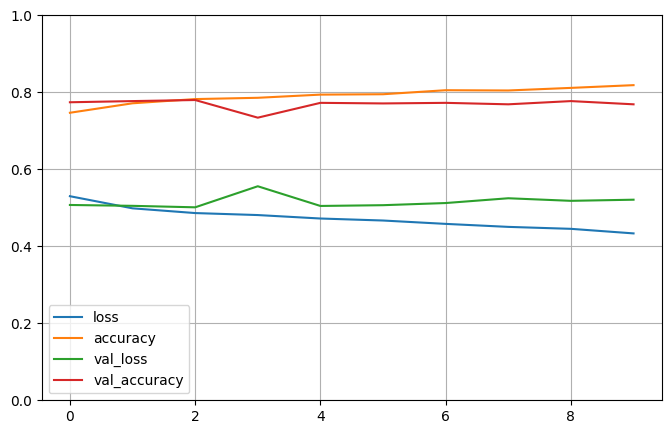

accuracy: 76.87%
Fold 1
Train set ones/size 7172 / 15956
Valid set ones/size 1707 / 3888
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
499/499 [==============================] - 2s 3ms/step - loss: 0.5338 - accuracy: 0.7441 - val_loss: 0.5156 - val_accuracy: 0.7616
Epoch 2/10
499/499 [==============================] - 1s 2ms/step - loss: 0.4940 - accuracy: 0.7800 - val_loss: 0.5110 - val_accuracy: 0.7629
Epoch 3/10
499/499 [==============================] - 1s 2ms/step - loss: 0.4854 - accuracy: 0.7804 - val_loss: 0.5169 - val_accuracy: 0.7605
Epoch 4/10
499/499 [==============================] - 1s 2ms/step - loss: 0.4793 - accuracy: 0.7875 - val_loss: 0.5174 - val_accuracy: 0.7577
Epoch 5/10
499/499 [==============================] - 1s 2ms/step - loss: 0.4676 - accuracy: 0.7947 - val_loss: 0.5354 - val_accuracy: 0.7541
Epoch 6/10
499/499 [==============================] - 1s 2ms/step - loss: 0.4575 - accuracy: 0.7989 - val_loss: 0.5338 - val_accuracy: 0.7526
Epoch 7/10
499/499 [

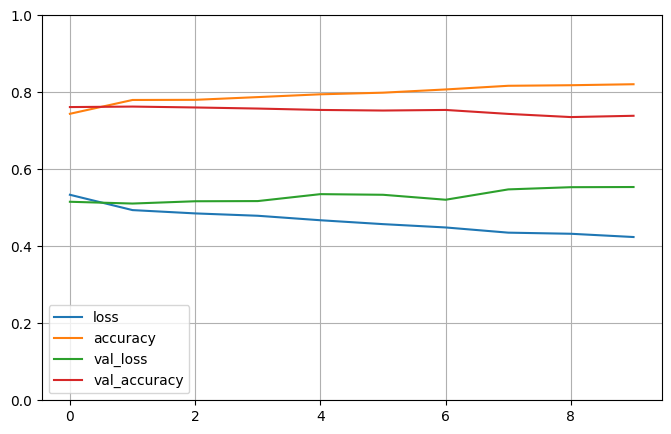

accuracy: 73.89%
Fold 2
Train set ones/size 7244 / 15855
Valid set ones/size 1635 / 3989
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
496/496 [==============================] - 2s 3ms/step - loss: 0.5366 - accuracy: 0.7455 - val_loss: 0.5062 - val_accuracy: 0.7633
Epoch 2/10
496/496 [==============================] - 2s 3ms/step - loss: 0.4967 - accuracy: 0.7761 - val_loss: 0.5035 - val_accuracy: 0.7721
Epoch 3/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4889 - accuracy: 0.7820 - val_loss: 0.5297 - val_accuracy: 0.7611
Epoch 4/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4823 - accuracy: 0.7868 - val_loss: 0.5035 - val_accuracy: 0.7766
Epoch 5/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4729 - accuracy: 0.7939 - val_loss: 0.5084 - val_accuracy: 0.7719
Epoch 6/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4641 - accuracy: 0.7987 - val_loss: 0.5127 - val_accuracy: 0.7656
Epoch 7/10
496/496 [

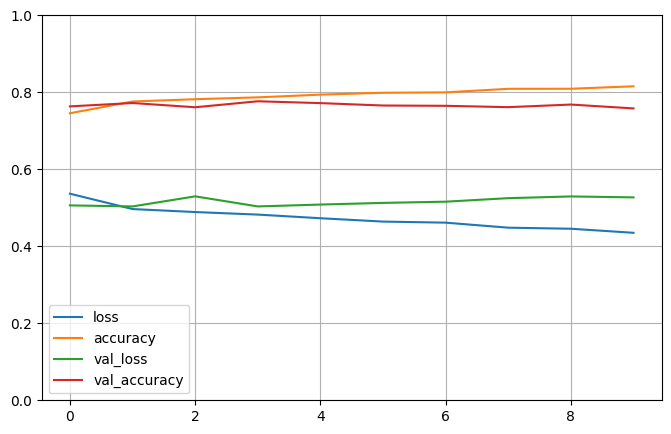

accuracy: 75.81%
Fold 3
Train set ones/size 7014 / 15849
Valid set ones/size 1865 / 3995
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
496/496 [==============================] - 2s 3ms/step - loss: 0.5391 - accuracy: 0.7401 - val_loss: 0.5075 - val_accuracy: 0.7682
Epoch 2/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4968 - accuracy: 0.7730 - val_loss: 0.5093 - val_accuracy: 0.7660
Epoch 3/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4825 - accuracy: 0.7838 - val_loss: 0.5326 - val_accuracy: 0.7577
Epoch 4/10
496/496 [==============================] - 1s 3ms/step - loss: 0.4736 - accuracy: 0.7902 - val_loss: 0.5175 - val_accuracy: 0.7582
Epoch 5/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4656 - accuracy: 0.7948 - val_loss: 0.5199 - val_accuracy: 0.7454
Epoch 6/10
496/496 [==============================] - 2s 3ms/step - loss: 0.4567 - accuracy: 0.8035 - val_loss: 0.5281 - val_accuracy: 0.7612
Epoch 7/10
496/496 [

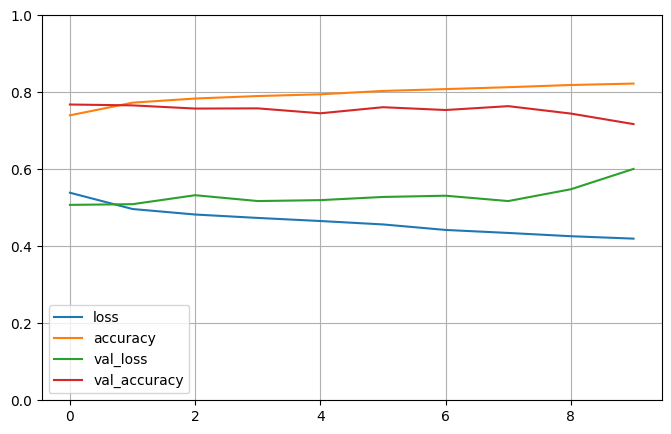

accuracy: 71.74%
Fold 4
Train set ones/size 7095 / 15820
Valid set ones/size 1784 / 4024
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
495/495 [==============================] - 2s 3ms/step - loss: 0.5271 - accuracy: 0.7496 - val_loss: 0.5257 - val_accuracy: 0.7488
Epoch 2/10
495/495 [==============================] - 1s 2ms/step - loss: 0.4919 - accuracy: 0.7796 - val_loss: 0.5327 - val_accuracy: 0.7453
Epoch 3/10
495/495 [==============================] - 1s 2ms/step - loss: 0.4828 - accuracy: 0.7838 - val_loss: 0.5314 - val_accuracy: 0.7517
Epoch 4/10
495/495 [==============================] - 1s 2ms/step - loss: 0.4786 - accuracy: 0.7878 - val_loss: 0.5291 - val_accuracy: 0.7587
Epoch 5/10
495/495 [==============================] - 1s 2ms/step - loss: 0.4692 - accuracy: 0.7952 - val_loss: 0.5342 - val_accuracy: 0.7594
Epoch 6/10
495/495 [==============================] - 1s 3ms/step - loss: 0.4621 - accuracy: 0.7977 - val_loss: 0.5421 - val_accuracy: 0.7550
Epoch 7/10
495/495 [

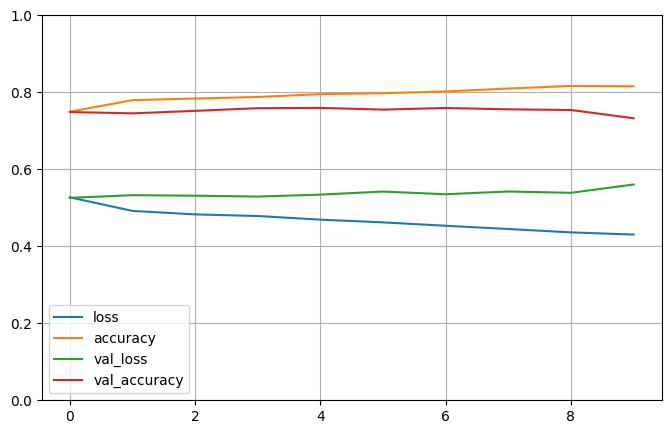

accuracy: 73.26%

Validation core mean 74.32% (+/- 1.83%)
2022-10-11 13:24:15.602311


In [12]:
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

print ("Cross valiation")
do_cross_validation(splitter,EPOCHS)
print(datetime.now())

# to do
Do train/valid split with respect to genes. 